# Projeto: Radar de Fraudes 💳
-  *Fraudes em e-commerce são práticas ilícitas que visam obter vantagens indevidas em transações online, como roubo de dados, uso de cartões clonados, phishing e engenharia social. Elas causam prejuízos financeiros significativos para empresas e clientes, além de danos à reputação das marcas e da confiança no ambiente digital.* 
-   *Nesse contexto, técnicas de ciência de dados e aprendizado de máquina têm se mostrado fundamentais para identificar padrões suspeitos e antecipar comportamentos fraudulentos. Modelos de detecção de fraude permitem analisar grandes volumes de dados em tempo real, oferecendo suporte à tomada de decisão e aumentando a eficiência dos sistemas de segurança.*

##  Objetivo do projeto
-  *Este notebook tem como objetivo explorar métodos de análise e modelagem preditiva aplicados à detecção de fraudes, utilizando dados históricos de transações. Ao longo do trabalho, serão abordadas etapas de preparação dos dados, exploração estatística, construção de modelos de machine learning e avaliação de desempenho.*

-  *A proposta é demonstrar como a aplicação prática de algoritmos pode contribuir para reduzir riscos, proteger clientes e fortalecer a confiança no ambiente digital.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import chi2, SelectKBest
import matplotlib.pyplot as plt
import shap
from IPython.display import Markdown

In [2]:
np.random.seed(1432)

## Etapas do projeto
- Implementar `Engenharia de Atributos` descobrir padrões ocultos e maximizar o desempenho dos algoritmos.
- Criar gráficos adequados para visualização de resultados e identificação de pontos decisivos na ocorrência das fraudes.
- Identificar transações fraudulentas utilizando técnicas e algoritmos mais adequadas para dados desbalanceados.
- Implementar `Explicabilidade` para maior transparência nas decisões do modelo.

In [3]:
dataset = pd.read_csv("Fraud_transactions.csv")
dataset.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


##### **Fonte dos dados (Kaggle)**
- https://www.kaggle.com/datasets/umuttuygurr/e-commerce-fraud-detection-dataset

## Insights iniciais sobre o dataset

In [4]:
shape = dataset.shape
Markdown(f"""##### *Tamanho do dataset*
*Há um total de **{shape[0]:,.0f}** registros no dataset disponibilizados em **{shape[1]}** colunas*""")

##### *Tamanho do dataset*
*Há um total de **299,695** registros no dataset disponibilizados em **17** colunas*

In [5]:
fraude_rate = dataset['is_fraud'].mean() * 100
Markdown(f"##### *Taxa de fraude atual:* **{fraude_rate:.2f}**%")

##### *Taxa de fraude atual:* **2.21**%

In [6]:
perdas = dataset.loc[dataset['is_fraud']==1, 'amount']
Markdown(f"##### Valor Total perdido com Fraudes: {perdas.sum():,.2f}")

##### Valor Total perdido com Fraudes: 3,907,435.45

In [7]:
Markdown(f"##### Valor Médio perdido com Fraudes: {perdas.mean():,.2f} ")

##### Valor Médio perdido com Fraudes: 590.96 

In [8]:
ganhos = dataset.loc[dataset['is_fraud']==0, 'amount']
Markdown(f"##### Valor total gerado com transações legítimas: {ganhos.sum():,.2f} ")

##### Valor total gerado com transações legítimas: 49,188,112.71 

In [9]:
Markdown(f"##### Valor Médio das transações legítimas: {ganhos.mean():,.2f} ")

##### Valor Médio das transações legítimas: 167.83 

In [10]:
distancia_fraudes = dataset.loc[dataset['is_fraud']==1, 'shipping_distance_km'].mean().round(2)
distancia_legitimas = dataset.loc[dataset['is_fraud']==0, 'shipping_distance_km'].mean().round(2)

In [20]:
Markdown(f"##### Nas compras fraudulentas a distância média entre origem e destino é de {distancia_fraudes:,.2f} km,\
 em contrapartida, compras legítimas tem uma distância média de {distancia_legitimas:,.2f} km. ")

##### Nas compras fraudulentas a distância média entre origem e destino é de 1,125.84 km, em contrapartida, compras legítimas tem uma distância média de 339.70 km. 

In [59]:
fraude_por_canal = dataset.loc[dataset['is_fraud']==1].groupby('channel')['is_fraud'].count().reset_index().sort_values(by='is_fraud', ascending=False)
prob = fraude_por_canal.loc[0, 'is_fraud'] / fraude_por_canal.loc[1, 'is_fraud']
Markdown(f"##### **Número de fraudes por canal de compra:**\n ##### O total de fraudes em compras feitas pela {fraude_por_canal.loc[1, 'channel'].upper()} é de `{fraude_por_canal.loc[1, 'is_fraud']}` --> ({100 - prob.round(4) *100}% do total de fraudes),\
          enquanto que compras pelo {fraude_por_canal.loc[0, 'channel'].upper()} totalizam `{fraude_por_canal.iloc[1, 1]}` fraudes ({prob.round(4) *100}% do total)." )


##### **Número de fraudes por canal de compra:**
 ##### O total de fraudes em compras feitas pela WEB é de `5426` --> (78.14% do total de fraudes),          enquanto que compras pelo APP totalizam `1186` fraudes (21.86% do total).

## Limpeza

In [12]:
# Verificação de duplicatas
dataset[dataset.duplicated()]

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud


In [13]:
# Alguns registros de transações fraudulentas
dataset[dataset['is_fraud']==1].head(5)

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
114,115,3,954,40,172.03,155.12,TR,DE,web,electronics,0,0,0,1,2024-03-30T09:55:57Z,3044.76,1
115,116,3,954,40,172.03,4.08,TR,DE,web,electronics,0,1,1,1,2024-04-13T08:22:02Z,2243.25,1
454,455,10,1742,54,154.87,1362.57,TR,TR,web,fashion,1,0,0,0,2024-03-21T02:30:10Z,15.19,1
488,489,10,1742,54,154.87,2290.22,TR,TR,web,gaming,0,1,1,1,2024-10-09T12:47:48Z,366.18,1
606,607,13,1532,41,114.66,141.57,US,US,web,electronics,0,1,1,0,2024-02-13T02:48:07Z,170.26,1


In [14]:
# Alguns registros de transações não fraudulentas
dataset[dataset['is_fraud']==0].head(10)

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0
5,6,1,141,47,147.93,224.82,FR,FR,web,travel,0,1,1,1,2024-01-26T22:05:08Z,289.06,0
6,7,1,141,47,147.93,125.98,FR,FR,app,electronics,0,1,1,1,2024-01-30T00:51:41Z,443.75,0
7,8,1,141,47,147.93,66.95,FR,RO,web,travel,0,1,1,1,2024-02-11T15:33:30Z,1390.59,0
8,9,1,141,47,147.93,261.58,FR,FR,app,grocery,0,0,0,0,2024-02-22T01:29:55Z,110.51,0
9,10,1,141,47,147.93,97.34,FR,FR,web,electronics,0,0,1,1,2024-03-09T11:13:19Z,232.34,0


## Engenharia de atributos

- Em transações fraudulentas características como *Hora do dia, fins de semana, e dia* são atributos importantes e que podem ser ***ALTAMENTE PREDITIVOS.***
   - Outras características importantes como *Idade da Conta, Valor Médio e total de transações por Usuário* foram previamente calculados.

In [15]:
dataset['transaction_time'] = pd.to_datetime(dataset['transaction_time'], format='%Y-%m-%dT%H:%M:%SZ')
dataset['transaction_time'].dtype

dtype('<M8[ns]')

In [16]:
dataset['transaction_time'][:5]

0   2024-01-06 04:09:39
1   2024-01-09 20:13:47
2   2024-01-12 06:20:11
3   2024-01-15 17:00:04
4   2024-01-17 01:27:31
Name: transaction_time, dtype: datetime64[ns]

In [17]:
dataset['year'] = dataset['transaction_time'].dt.year
dataset['month'] = dataset['transaction_time'].dt.month
dataset['day'] = dataset['transaction_time'].dt.day
dataset['day_name'] = dataset['transaction_time'].dt.day_name()
dataset['is_weekend'] = dataset['day_name'].isin(['Friday', 'Saturday', 'Sunday']).astype(int)
dataset.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,...,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud,year,month,day,day_name,is_weekend
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,...,1,1,2024-01-06 04:09:39,370.95,0,2024,1,6,Saturday,1
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,...,0,0,2024-01-09 20:13:47,149.62,0,2024,1,9,Tuesday,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,...,1,1,2024-01-12 06:20:11,164.08,0,2024,1,12,Friday,1
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,...,1,1,2024-01-15 17:00:04,397.40,0,2024,1,15,Monday,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,...,1,1,2024-01-17 01:27:31,935.28,0,2024,1,17,Wednesday,0


In [18]:
colunas_traduzidas = {
    'transaction_id': 'id_transacao',
    'user_id': 'id_usuario',
    'account_age_days': 'idade_conta_dias',
    'total_transactions_user': 'total_transacoes_usuario',
    'avg_amount_user': 'valor_medio_usuario',
    'amount': 'valor',
    'country': 'pais',
    'bin_country': 'pais_cartao',
    'channel': 'canal',
    'merchant_category': 'categoria_comerciante',
    'promo_used': 'promocao_usada',
    'avs_match': 'verificacao_endereco',
    'cvv_result': 'resultado_cvv',
    'three_ds_flag': 'autenticacao_3ds',
    'transaction_time': 'hora_transacao',
    'shipping_distance_km': 'distancia_envio_km',
    'is_fraud': 'fraude',
    'year': 'ano',
    'month': 'mes',
    'day': 'dia',
    'day_name': 'dia_semana',
    'is_weekend': 'fim_de_semana'
}

In [19]:
# Renomeação das colunas para o português, para melhor entendimento
dataset.rename(columns=colunas_traduzidas, inplace=True)
dataset.columns

Index(['id_transacao', 'id_usuario', 'idade_conta_dias',
       'total_transacoes_usuario', 'valor_medio_usuario', 'valor', 'pais',
       'pais_cartao', 'canal', 'categoria_comerciante', 'promocao_usada',
       'verificacao_endereco', 'resultado_cvv', 'autenticacao_3ds',
       'hora_transacao', 'distancia_envio_km', 'fraude', 'ano', 'mes', 'dia',
       'dia_semana', 'fim_de_semana'],
      dtype='object')

## Análise Exploratória

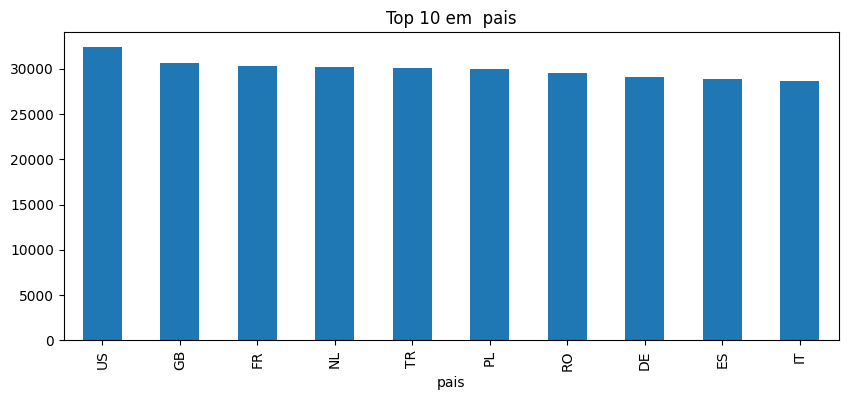

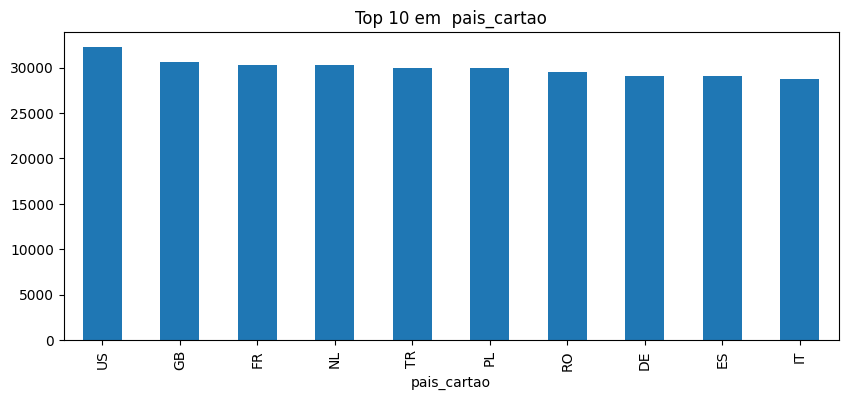

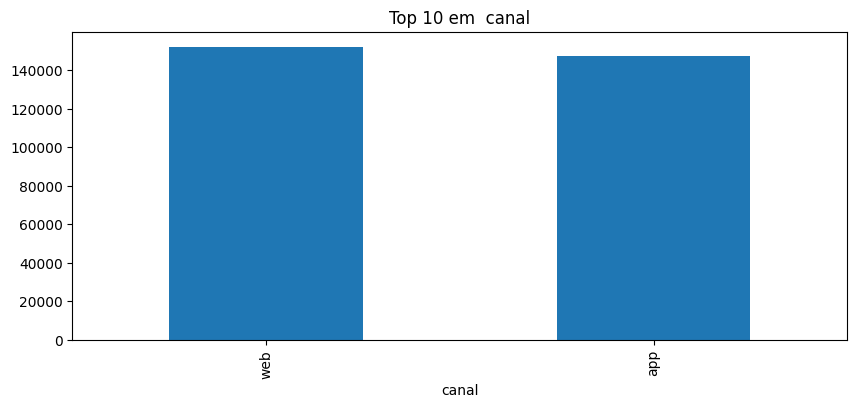

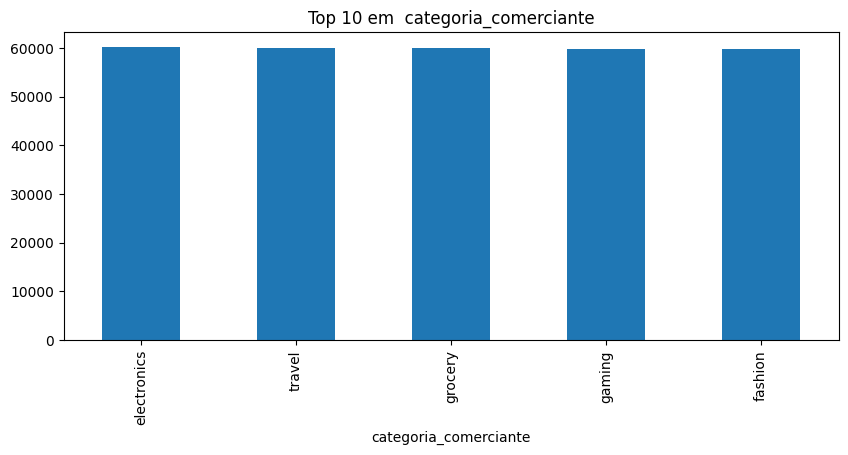

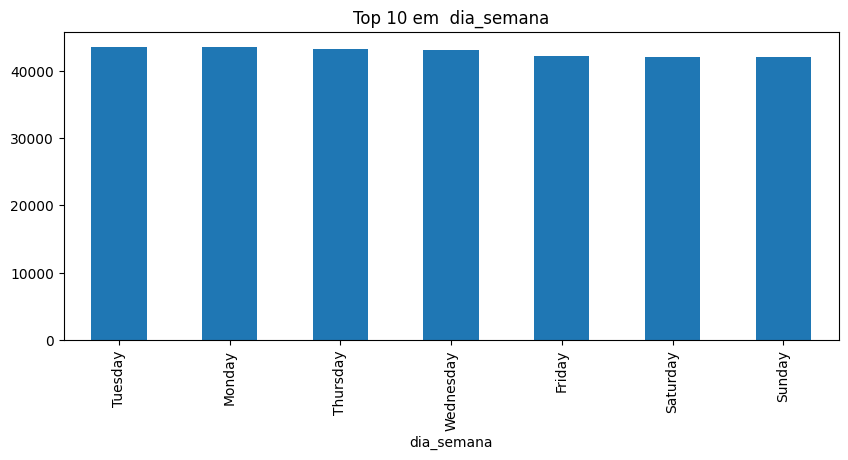

In [20]:
categoricas = dataset.select_dtypes(include=['object']).columns
for cat in categoricas:
    plt.figure(figsize=(10,4))
    dataset[cat].value_counts().head(10).plot(kind='bar')    
    plt.title(f"Top 10 em  {cat}")
    plt.show()

##### Interpretação dos gráficos: 
- Os gráficos mostram um conjunto de dados balanceados. Não há variação significativa nos dados originais.

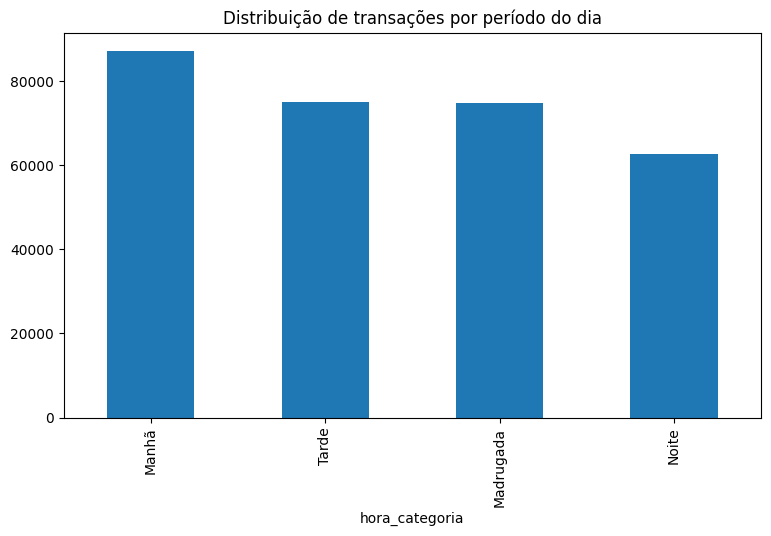

In [21]:
# Extração do período do dia pode revelar padrões e insights interessantes.
dataset['hora_categoria'] = dataset['hora_transacao'].apply(lambda X: 'Manhã' if 5 <=X.hour < 12
                                                             else 'Tarde' if 12 <= X.hour < 18
                                                             else 'Noite' if 18 <= X.hour < 23
                                                             else 'Madrugada')
plt.figure(figsize=(9,5))
dataset['hora_categoria'].value_counts().plot(kind='bar')    
plt.title("Distribuição de transações por período do dia")
plt.show()

**O período da manhã é onde se encontra a maioria das transações. Esse período pode ser explorado para implementar campanhas de marketing mais eficientes, por exemplo.**

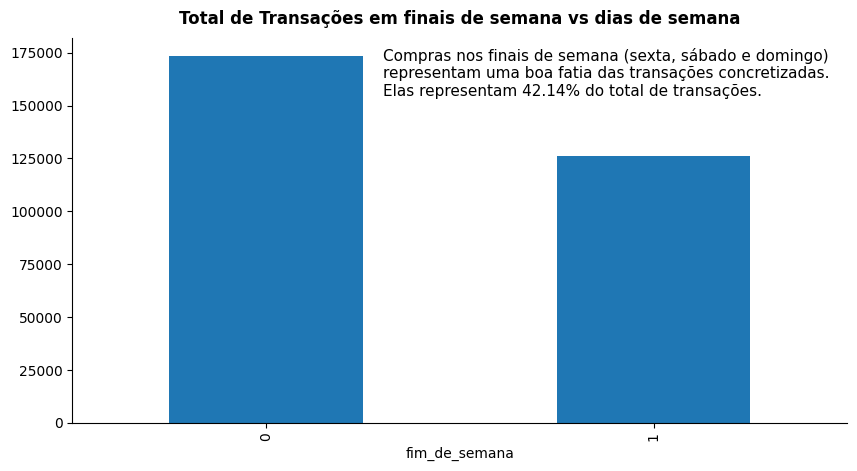

In [22]:
plt.figure(figsize=(10,5))
dataset['fim_de_semana'].value_counts().plot(kind='bar')
plt.title("Total de Transações em finais de semana vs dias de semana", 
          pad=10, fontweight='bold')
plt.annotate(f"""        Compras nos finais de semana (sexta, sábado e domingo) 
        representam uma boa fatia das transações concretizadas.
        Elas representam {(dataset['fim_de_semana'].value_counts(normalize=True)[1] * 100).round(2)}% do total de transações.""",
             xy=(0.28,0.85), xytext=(0.35, 0.85), xycoords="axes fraction", size=11)
sns.despine(top=True, right=True)
plt.show()

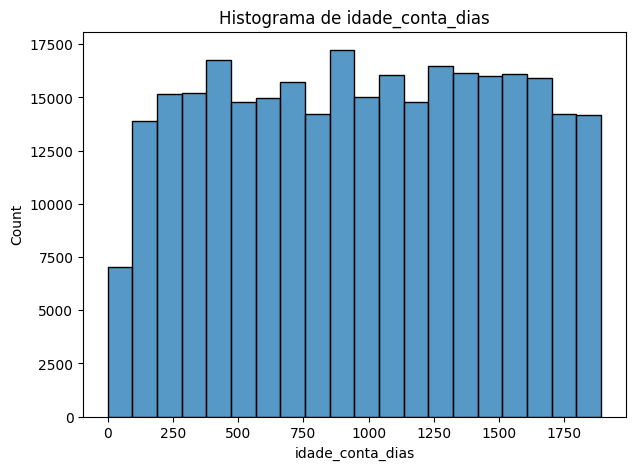


Resumo Estatístico: 
count    299695.000000
mean        973.397871
std         525.241409
min           1.000000
25%         516.000000
50%         975.000000
75%        1425.000000
max        1890.000000
Name: idade_conta_dias, dtype: float64


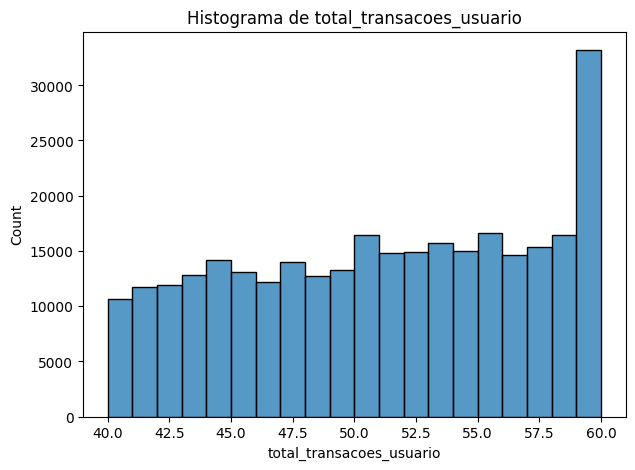


Resumo Estatístico: 
count    299695.000000
mean         50.673321
std           5.976391
min          40.000000
25%          46.000000
50%          51.000000
75%          56.000000
max          60.000000
Name: total_transacoes_usuario, dtype: float64


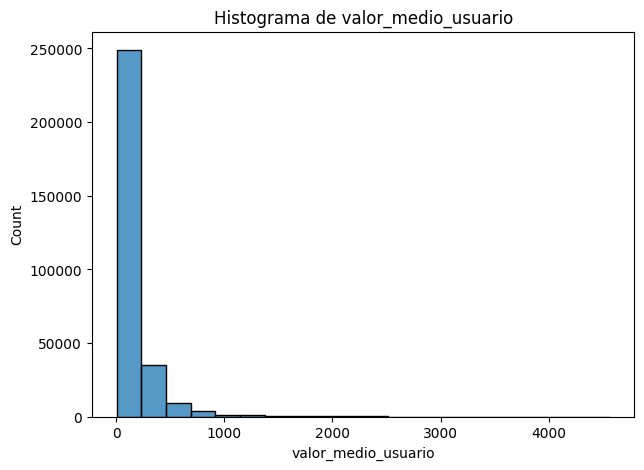


Resumo Estatístico: 
count    299695.000000
mean        148.142973
std         200.364624
min           3.520000
25%          46.190000
50%          90.130000
75%         173.450000
max        4565.290000
Name: valor_medio_usuario, dtype: float64


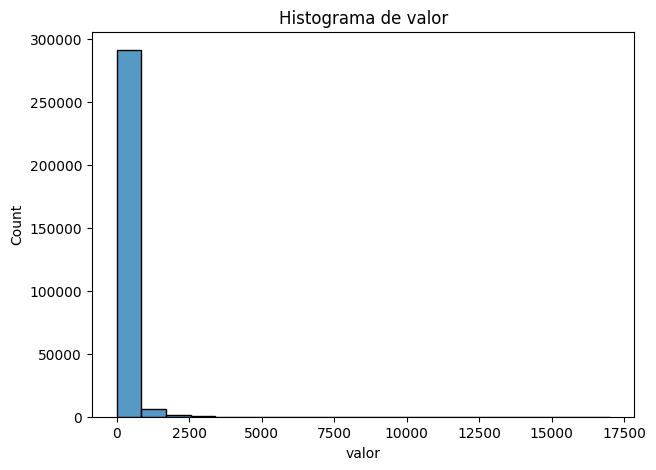


Resumo Estatístico: 
count    299695.000000
mean        177.165279
std         306.926507
min           1.000000
25%          42.100000
50%          89.990000
75%         191.110000
max       16994.740000
Name: valor, dtype: float64


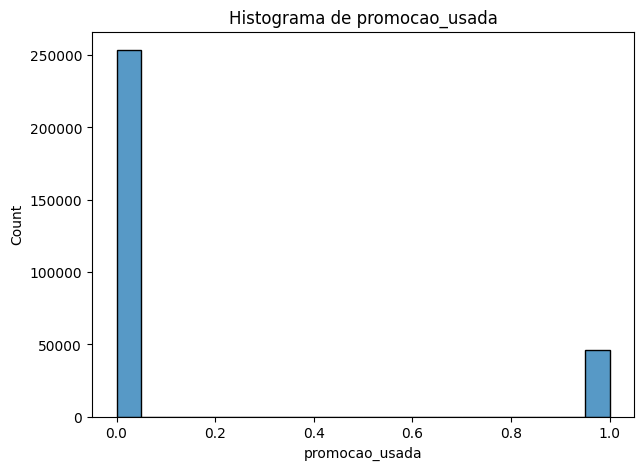


Resumo Estatístico: 
count    299695.000000
mean          0.153640
std           0.360603
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: promocao_usada, dtype: float64


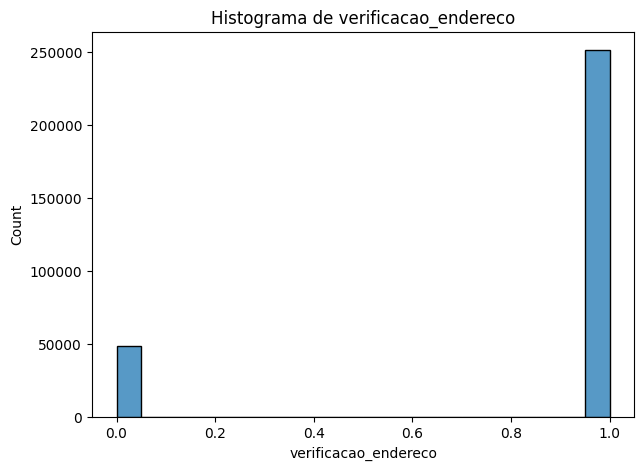


Resumo Estatístico: 
count    299695.000000
mean          0.837999
std           0.368453
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: verificacao_endereco, dtype: float64


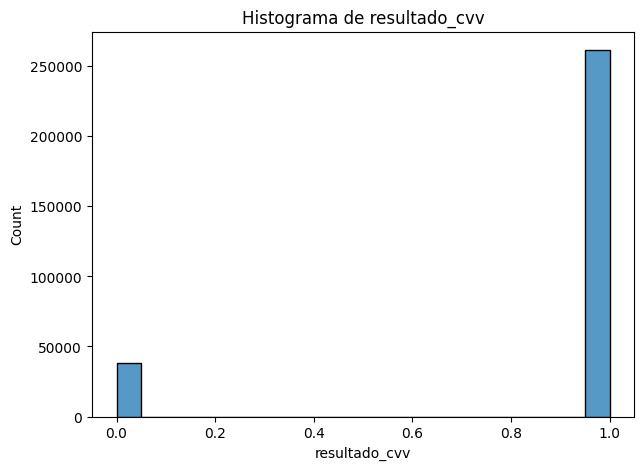


Resumo Estatístico: 
count    299695.000000
mean          0.872110
std           0.333968
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: resultado_cvv, dtype: float64


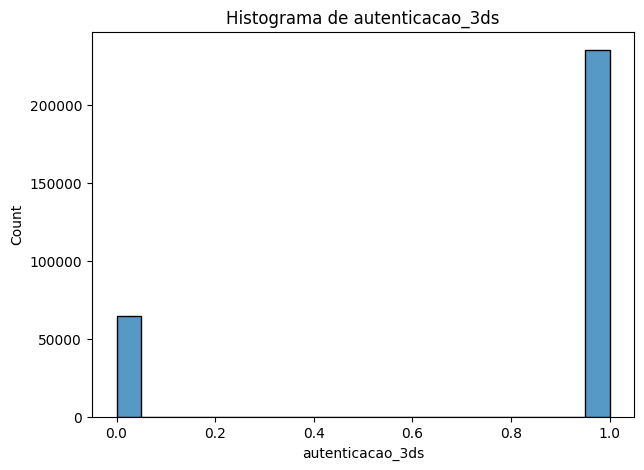


Resumo Estatístico: 
count    299695.000000
mean          0.784588
std           0.411109
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: autenticacao_3ds, dtype: float64


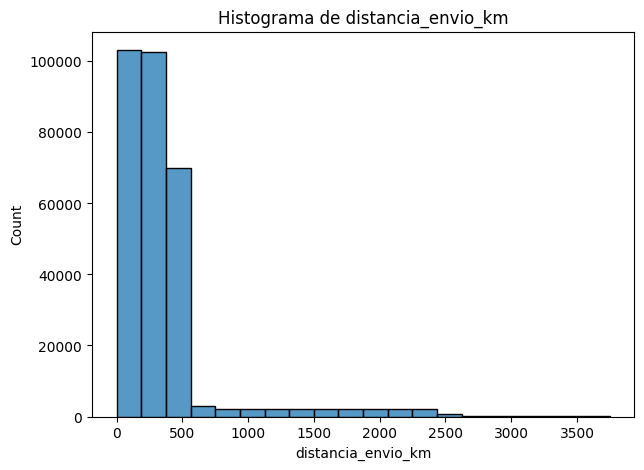


Resumo Estatístico: 
count    299695.000000
mean        357.049028
std         427.672074
min           0.000000
25%         136.600000
50%         273.020000
75%         409.180000
max        3748.560000
Name: distancia_envio_km, dtype: float64


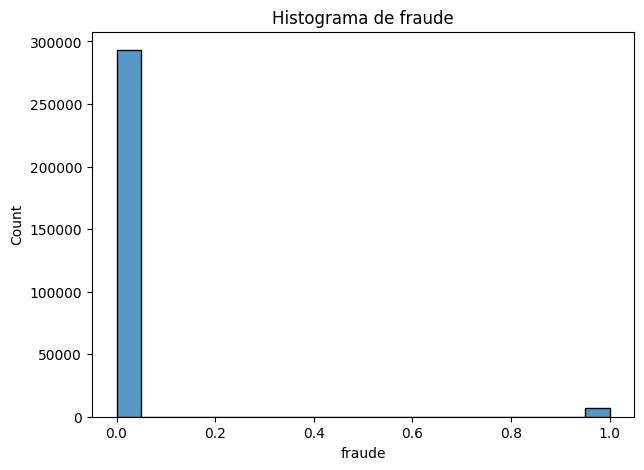


Resumo Estatístico: 
count    299695.000000
mean          0.022062
std           0.146887
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: fraude, dtype: float64


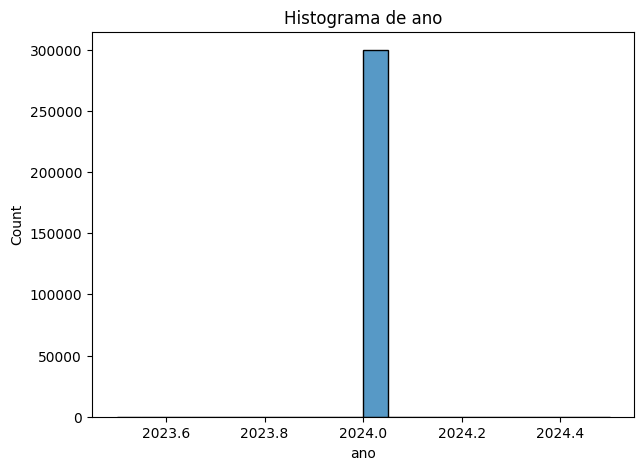


Resumo Estatístico: 
count    299695.0
mean       2024.0
std           0.0
min        2024.0
25%        2024.0
50%        2024.0
75%        2024.0
max        2024.0
Name: ano, dtype: float64


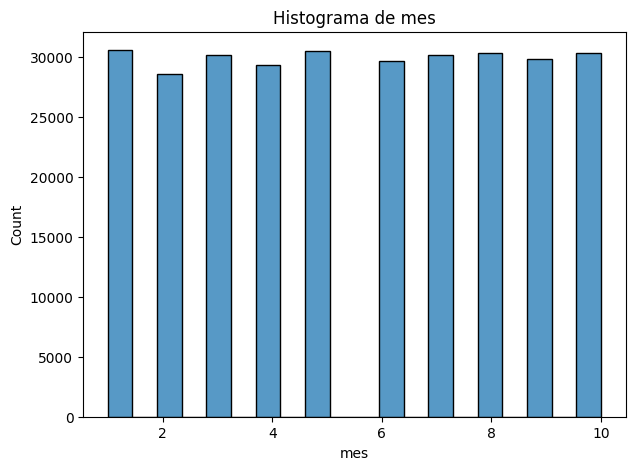


Resumo Estatístico: 
count    299695.000000
mean          5.515874
std           2.875234
min           1.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          10.000000
Name: mes, dtype: float64


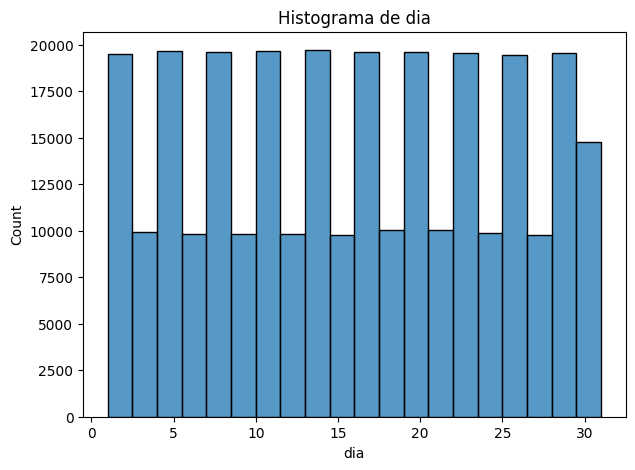


Resumo Estatístico: 
count    299695.000000
mean         15.753843
std           8.805165
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: dia, dtype: float64


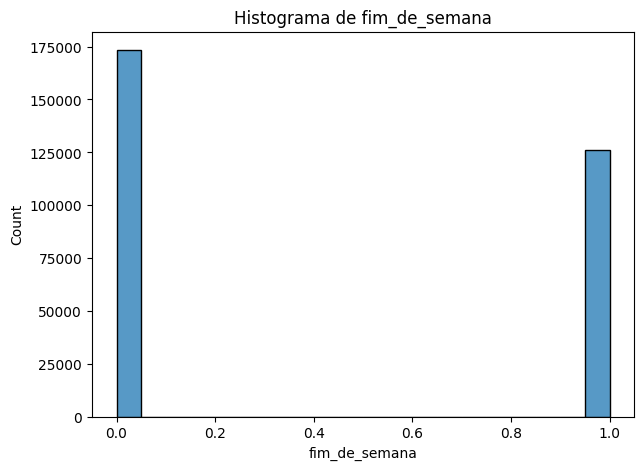


Resumo Estatístico: 
count    299695.000000
mean          0.421398
std           0.493784
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: fim_de_semana, dtype: float64


In [23]:
numericas = dataset.select_dtypes(include=np.number)
numericas.drop(['id_transacao', 'id_usuario'], inplace=True, axis=1)
for col in numericas:
    plt.figure(figsize=(7,5))
    sns.histplot(x=col, bins=20, data = dataset)
    plt.title(f"Histograma de {col}")
    plt.show()
    print("\nResumo Estatístico: ")
    print(dataset[col].describe())

##### Interpretação dos gráficos
**Os gráficos acima revelam um conjunto de dados balanceado quanto às características dos clientes. Há apenas alguns valores elevados em variáveis como Valor Médio da transação, 
valor da transação e distância de envio. Esses valores podem ser importantes para que o algoritmo capte transações com alto potencial de para fraude.**

## Modelagem Preditiva

### Abordagem utilizada

- ✅ Desempenho dos Modelos balanceados `scale_pos_weight`
- 🔍 Seleção de características mais importantes com `SelectKBest`
- ⚙️ Modelos utilizados **(Robustos em dados desbalanceados)**:
  - XGBoost
  - LightGBM  

In [24]:
previsores = dataset.drop(['fraude', 'id_transacao', 
                           'id_usuario', 'hora_transacao', 'hora_categoria', 'ano'], axis=1)
classe = dataset['fraude']
Markdown(f"""##### Colunas restantes no dataset antes da seleção dos atributos mais importantes -> **{len(previsores.columns)} no total**:
{dataset.columns.values}""")

##### Colunas restantes no dataset antes da seleção dos atributos mais importantes -> **17 no total**:
['id_transacao' 'id_usuario' 'idade_conta_dias' 'total_transacoes_usuario'
 'valor_medio_usuario' 'valor' 'pais' 'pais_cartao' 'canal'
 'categoria_comerciante' 'promocao_usada' 'verificacao_endereco'
 'resultado_cvv' 'autenticacao_3ds' 'hora_transacao' 'distancia_envio_km'
 'fraude' 'ano' 'mes' 'dia' 'dia_semana' 'fim_de_semana' 'hora_categoria']

In [25]:
X_treino, X_teste, y_treino, y_teste = train_test_split(previsores, 
                                                    classe, test_size=0.25, random_state=1432)
X_treino.shape, X_teste.shape

((224771, 17), (74924, 17))

In [26]:
for col in categoricas:
    le = LabelEncoder()
    X_treino[col] = le.fit_transform(X_treino[col])
    X_teste[col] = le.transform(X_teste[col])    

In [27]:
seletor = SelectKBest(chi2, k=10)
X_treino = seletor.fit_transform(X_treino, y_treino)
X_teste = seletor.transform(X_teste)

In [28]:
colunas_selecionadas = previsores.columns[seletor.get_support()]
Markdown(f"""##### Colunas selectionadas pelo seletor de atributos:
{colunas_selecionadas.values}""")

##### Colunas selectionadas pelo seletor de atributos:
['idade_conta_dias' 'valor_medio_usuario' 'valor' 'pais' 'canal'
 'promocao_usada' 'verificacao_endereco' 'resultado_cvv'
 'autenticacao_3ds' 'distancia_envio_km']

In [29]:
X_treino.shape

(224771, 10)

## Modelo 1 (XGBClassifier)

In [30]:
scale = sum(y_treino==0) / sum(y_treino==1)
scale

44.27109768378651

In [31]:
# Desbalanceamento dos dados
Markdown(f"**Para cada transação fraudulenta há aproximadamente `{int(scale -1)}` transações não fraudulentas** ")

**Para cada transação fraudulenta há aproximadamente `43` transações não fraudulentas** 

In [32]:
xgb = XGBClassifier(scale_pos_weight=scale, enable_categorical=True)
xgb.fit(X_treino, y_treino)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [33]:
previsoes = xgb.predict(X_teste)
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     73277
           1       0.42      0.84      0.56      1647

    accuracy                           0.97     74924
   macro avg       0.71      0.91      0.77     74924
weighted avg       0.98      0.97      0.98     74924



In [34]:
confusion_xgb = confusion_matrix(y_teste, previsoes)
confusion_xgb

array([[71349,  1928],
       [  257,  1390]], dtype=int64)

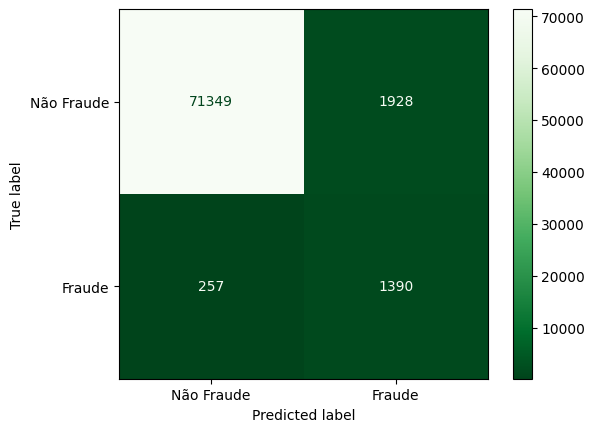

In [35]:
ConfusionMatrixDisplay(confusion_xgb, 
                       display_labels=['Não Fraude', 'Fraude']).plot(cmap='Greens_r');

## Modelo 2 (LightGBM Classifier)

In [36]:
lgbm = LGBMClassifier(scale_pos_weight=scale)
lgbm.fit(X_treino, y_treino)

[LightGBM] [Info] Number of positive: 4965, number of negative: 219806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 224771, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.022089 -> initscore=-3.790332
[LightGBM] [Info] Start training from score -3.790332


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [37]:
previsoes_lgbm = lgbm.predict(X_teste)
print(classification_report(y_teste, previsoes_lgbm))

C:\Users\roni_\anaconda3\envs\ambiente_torch\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     73277
           1       0.30      0.90      0.45      1647

    accuracy                           0.95     74924
   macro avg       0.65      0.93      0.71     74924
weighted avg       0.98      0.95      0.96     74924



In [38]:
confusion_lgbm = confusion_matrix(y_teste, previsoes_lgbm)
confusion_lgbm

array([[69839,  3438],
       [  168,  1479]], dtype=int64)

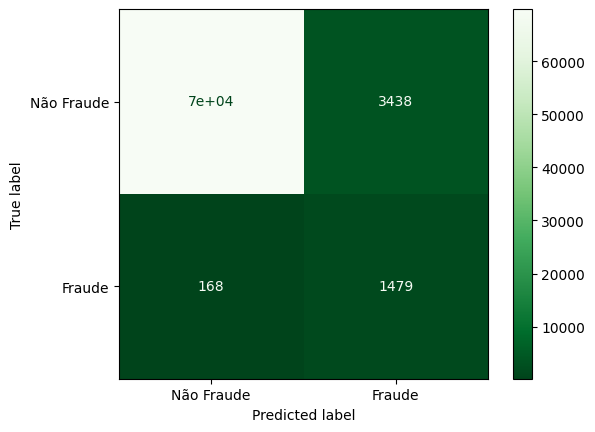

In [39]:
# Resultados Iniciais LGBM
ConfusionMatrixDisplay(confusion_lgbm, 
                       display_labels=['Não Fraude', 'Fraude']).plot(cmap='Greens_r');

### Conclusões Iniciais sobre o desempenho dos Modelos:

- Ambos os modelos conseguiram identificar uma quantidade significativa de fraudes, equilibrando ligeiramente bem entre transações fraudulentas e legítimas detectadas.
+ Porém, para identificar essas transações fraudulentas, ambos os modelos bloquearam uma quantidade significativa de transações legítimas (como pode ser visto acima **3438 transações legítimas bloqueadas incorretamente**).
+ A técnica utilizada abaixo serve para mitigar essa deficiência, ajudando os modelos a `ENCONTRAR O PONTO IDEAL DE TROCA` onde uma quantidade satisfatória de transações fraudulentas são identificadas, ao mesmo tempo que o menor número possível de transações legítimas são bloqueadas pelo modelo.

-------------------------------------------------------------------------------------------------------------------------------

## Tuning de hiper-parâmetros com Otimização Bayesiana (XGBClassifier)

In [64]:
Markdown(f"""Como visto anteriormente, as fraudes causam um grande prejuízo chegando a atingir um total de **{perdas.sum():,.2f}.** 
Para contornar esse problema a métrica escolhida foi o `f1_macro`. Essa métrica busca maximizar a detecção de transações fraudulentas, balanceando 
entre o número de transações fraudulentas e legítimas identificadas corretamente.
já a `Otimização Bayesiana` faz uma busca inteligente pelos melhores hiper-parâmetros do Modelo.
A busca será feita com os algoritmos `XGBoost` e `LGBMClassifier` que obteviveram um desempenho semelhante nos testes preliminares, 
alcançando um bom balanceamento entre transações legítimas e fraudulentas corretamente identificadas.""")

Como visto anteriormente, as fraudes causam um grande prejuízo chegando a atingir um total de **3,907,435.45.** 
Para contornar esse problema a métrica escolhida foi o `f1_macro`. Essa métrica busca maximizar a detecção de transações fraudulentas, balanceando 
entre o número de transações fraudulentas e legítimas identificadas corretamente.
já a `Otimização Bayesiana` faz uma busca inteligente pelos melhores hiper-parâmetros do Modelo.
A busca será feita com os algoritmos `XGBoost` e `LGBMClassifier` que obteviveram um desempenho semelhante nos testes preliminares, 
alcançando um bom balanceamento entre transações legítimas e fraudulentas corretamente identificadas.

In [41]:
search_spaces={
            'max_depth': (3, 20),
            'learning_rate': (0.01, 0.4),
            'n_estimators': (100, 1000),
            'subsample': (0.5, 1.0),
            'colsample_bytree': (0.5, 1.0),
            'gamma': (0, 5),
            'reg_alpha': (1e-4, 0.7),
           'reg_lambda': (1e-4, 0.85) }

In [42]:
bayes_search = BayesSearchCV(XGBClassifier(scale_pos_weight=scale), search_spaces, scoring='f1_macro',
                             n_jobs=-1, cv=5, verbose=3, error_score='raise', n_iter=64, random_state=1432)
bayes_search.fit(X_treino, y_treino) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

,estimator,"XGBClassifier...ree=None, ...)"
,search_spaces,"{'colsample_bytree': (0.5, ...), 'gamma': (0, ...), 'learning_rate': (0.01, ...), 'max_depth': (3, ...), ...}"
,optimizer_kwargs,None
,n_iter,64
,scoring,'f1_macro'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [43]:
best_parameters = bayes_search.best_params_
best_score = bayes_search.best_score_

In [44]:
print("Melhores parâmetros encontrados:")
print(best_parameters)

Melhores parâmetros encontrados:
OrderedDict([('colsample_bytree', 0.5), ('gamma', 0), ('learning_rate', 0.2262242953419629), ('max_depth', 20), ('n_estimators', 100), ('reg_alpha', 0.7), ('reg_lambda', 0.0001), ('subsample', 1.0)])


In [45]:
print("Melhor f1-Score alcançado: {:0.2f}% ".format(best_score * 100))

Melhor f1-Score alcançado: 89.55% 


In [46]:
prev_bayes = bayes_search.predict_proba(X_teste)
prev_bayes = (prev_bayes > 0.3).astype(int)[:,1]
prev_bayes[:5]

array([0, 0, 0, 0, 0])

## Tuning de hiper-parâmetros com Otimização Bayesiana (LGBMClassifier)

In [47]:
param_space = {
    'num_leaves': Integer(20, 100),
    'max_depth': Integer(3, 15),
    'learning_rate': Real(0.005, 0.2, prior='log-uniform'),
    'n_estimators': Integer(100, 500),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'reg_alpha': Real(1e-3, 10.0, prior='log-uniform'),
    'reg_lambda': Real(1e-3, 10.0, prior='log-uniform'),
    'scale_pos_weight': Real(1, 50, prior='log-uniform'),  # importante para desbalanceamento
    'boosting_type': Categorical(['gbdt', 'dart'])    
}


In [48]:
bayes_search_lgbm = BayesSearchCV(
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    search_spaces=param_space,
    n_iter=64,
    scoring='f1_macro',  
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=1432
)

In [49]:
bayes_search_lgbm.fit(X_treino, y_treino)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

,estimator,LGBMClassifie...ndom_state=42)
,search_spaces,"{'boosting_type': Categorical(c...), prior=None), 'colsample_bytree': Real(low=0.5,...m='normalize'), 'learning_rate': Real(low=0.00...m='normalize'), 'max_depth': Integer(low=3...m='normalize'), ...}"
,optimizer_kwargs,None
,n_iter,64
,scoring,'f1_macro'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,5


In [50]:
best_parameters = bayes_search_lgbm.best_params_
best_score = bayes_search_lgbm.best_score_

In [72]:
print(f"Melhor F1 Score Encontrado: {best_score*100:.2f}")

Melhor F1 Score Encontrado: 90.29


In [51]:
print("Melhores parâmetros encontrados:")
print(best_parameters)

Melhores parâmetros encontrados:
OrderedDict([('boosting_type', 'dart'), ('colsample_bytree', 0.7282628285096816), ('learning_rate', 0.2), ('max_depth', 14), ('min_child_samples', 74), ('n_estimators', 486), ('num_leaves', 20), ('reg_alpha', 1.948983261569964), ('reg_lambda', 10.0), ('scale_pos_weight', 1.2097547688535297), ('subsample', 0.5)])


In [52]:
prev_bayes_lgbm = bayes_search_lgbm.predict_proba(X_teste)
prev_bayes_lgbm = (prev_bayes_lgbm > 0.3).astype(int)[:,1]
prev_bayes[:5]

C:\Users\roni_\anaconda3\envs\ambiente_torch\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


array([0, 0, 0, 0, 0])

# Avaliacao dos Resultados

## Resultado Final XGBoost

In [53]:
confusion_bayes = confusion_matrix(y_teste, prev_bayes)
classification = classification_report(y_teste, prev_bayes)

In [54]:
print("Classification Report:\n %s " % classification)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     73277
           1       0.80      0.76      0.78      1647

    accuracy                           0.99     74924
   macro avg       0.90      0.88      0.89     74924
weighted avg       0.99      0.99      0.99     74924
 


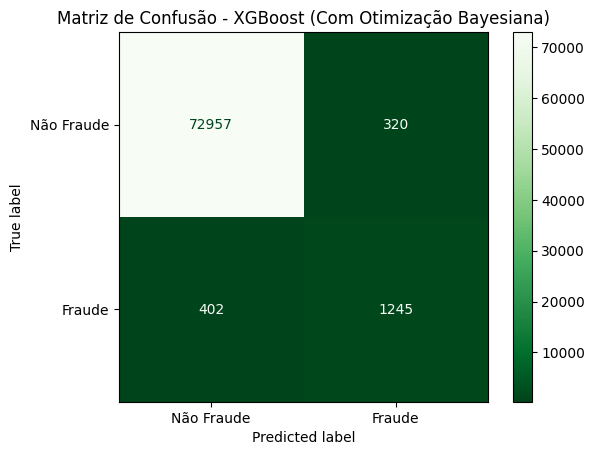

In [55]:
ConfusionMatrixDisplay(confusion_bayes,
                       display_labels=['Não Fraude', 'Fraude']).plot(cmap='Greens_r')
plt.title("Matriz de Confusão - XGBoost (Com Otimização Bayesiana)");

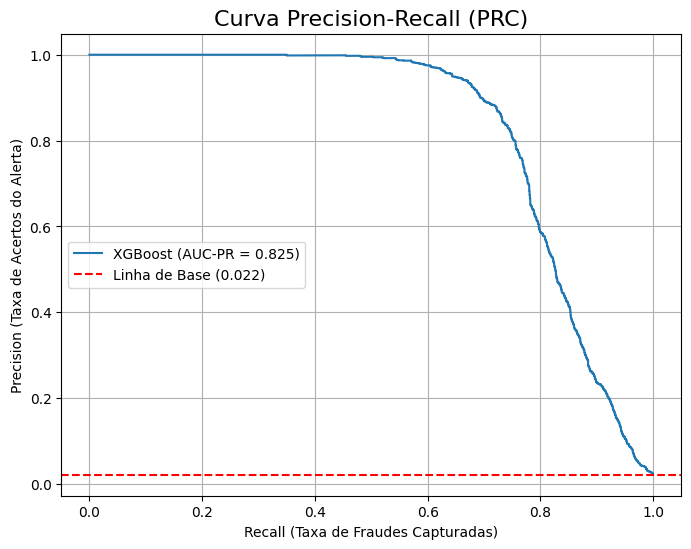

In [56]:
y_probs = bayes_search.predict_proba(X_teste)[:, 1]

# Calcular a curva
precision, recall, thresholds = precision_recall_curve(y_teste, y_probs)
pr_auc = auc(recall, precision)

# Plotar a Curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AUC-PR = {pr_auc:.3f})')

# Linha de base (Baseline): Proporção da classe positiva (fraude)
baseline = len(y_teste[y_teste==1]) / len(y_teste)
plt.axhline(baseline, linestyle='--', color='red', label=f'Linha de Base ({baseline:.3f})')

plt.xlabel('Recall (Taxa de Fraudes Capturadas)')
plt.ylabel('Precision (Taxa de Acertos do Alerta)')
plt.title('Curva Precision-Recall (PRC)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

## Resultado Final LGBM

In [57]:
confusion_bayes_lgbm = confusion_matrix(y_teste, prev_bayes_lgbm)
classification_lgbm = classification_report(y_teste, prev_bayes_lgbm)

In [58]:
print("Classification Report:\n %s " % classification_lgbm)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     73277
           1       0.80      0.77      0.78      1647

    accuracy                           0.99     74924
   macro avg       0.90      0.88      0.89     74924
weighted avg       0.99      0.99      0.99     74924
 


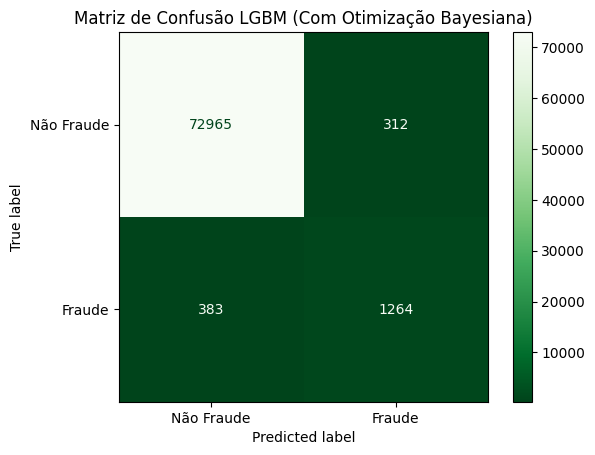

In [59]:
ConfusionMatrixDisplay(confusion_bayes_lgbm,
                       display_labels=['Não Fraude', 'Fraude']).plot(cmap='Greens_r')
plt.title("Matriz de Confusão LGBM (Com Otimização Bayesiana)");

C:\Users\roni_\anaconda3\envs\ambiente_torch\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


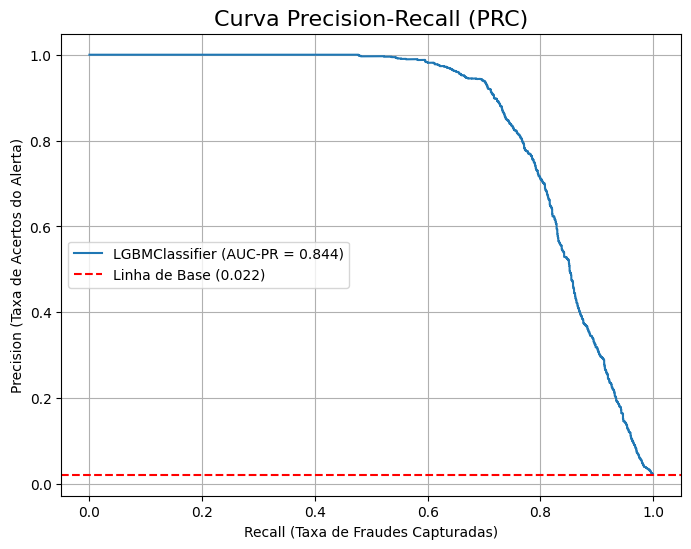

In [60]:
y_probs = bayes_search_lgbm.predict_proba(X_teste)[:, 1] # Previsões LGBM

# Calcular a curva
precision, recall, thresholds = precision_recall_curve(y_teste, y_probs)
pr_auc = auc(recall, precision)

# Plotar a Curva Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'LGBMClassifier (AUC-PR = {pr_auc:.3f})')

# Linha de base (Baseline): Proporção da classe positiva (fraude)
baseline = len(y_teste[y_teste==1]) / len(y_teste)
plt.axhline(baseline, linestyle='--', color='red', label=f'Linha de Base ({baseline:.3f})')

plt.xlabel('Recall (Taxa de Fraudes Capturadas)')
plt.ylabel('Precision (Taxa de Acertos do Alerta)')
plt.title('Curva Precision-Recall (PRC)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

✅ O que podemos concluir?
- O modelo LGBM supera amplamente a linha de base, indicando que ele consegue identificar fraudes com boa precisão e recall.
- A alta AUC-PR (84.4) mostra que o modelo mantém um bom equilíbrio entre capturar fraudes e evitar alarmes falsos.
- Como o baseline é muito baixo (2.2%), isso reforça que o problema é altamente desbalanceado — típico em detecção de fraudes.

-------------------------------------------------------------------------------------------------------------------------------

# Explicabilidade Global:

## Baseado em quê o modelo toma suas decisões?
Usamos os **Valores SHAP** para entender o impacto médio de cada característica do cliente em todas as transações.

O gráfico de resumo (SHAP Summary Plot) a seguir revela:
- **Importância (Eixo Y):** Onde o modelo mais foca para fazer a previsão.
- **Magnitude (Eixo X):** O quão grande é o impacto de cada característica.

In [61]:
df_previsores = pd.DataFrame(X_teste, columns=colunas_selecionadas)
df_teste = pd.concat((df_previsores, pd.Series(y_teste.values, name='fraude')), axis=1)
df_teste.head(3)

,idade_conta_dias,valor_medio_usuario,valor,pais,canal,promocao_usada,verificacao_endereco,resultado_cvv,autenticacao_3ds,distancia_envio_km,fraude
0,710.0,63.47,71.25,1.0,1.0,0.0,1.0,1.0,1.0,207.59,0
1,274.0,109.14,111.44,6.0,1.0,0.0,1.0,1.0,1.0,70.85,0
2,1740.0,123.02,64.39,7.0,1.0,0.0,1.0,1.0,0.0,1.01,0


C:\Users\roni_\anaconda3\envs\ambiente_torch\lib\site-packages\shap\explainers\_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\roni_\AppData\Local\Temp\ipykernel_23132\3437419491.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, df_previsores, plot_type="bar", show=False, feature_names=colunas_selecionadas)


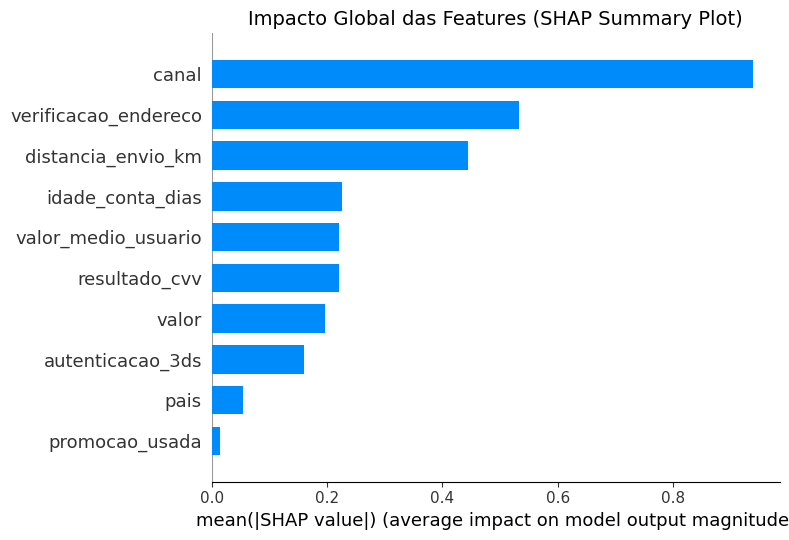

In [62]:
# Inicializar o Explainer e Calcular Valores SHAP ---
# O TreeExplainer é otimizado para modelos baseados em árvore
explainer = shap.TreeExplainer(lgbm) 

# Calcular valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(df_previsores) 

# Gráfico de Resumo (Feature Importance Global) ---
plt.figure(figsize=(12,6))
plt.title("Impacto Global das Features (SHAP Summary Plot)", fontsize=14)
# O Summary Plot mostra a importância geral (tamanho da barra) e a direção (cor)
shap.summary_plot(shap_values, df_previsores, plot_type="bar", show=False, feature_names=colunas_selecionadas)
plt.tight_layout()
plt.show()

## Interpretação do gráfico 1 (Interpretabilidade Global):
O gráfico acima mostra quais variáveis mais influenciam o modelo na detecção de fraudes.

**Principais influenciadores:**
1) distancia_envio_km: Quanto maior a distância entre origem e destino, maior a chance de fraude.

2) verificacao_endereco: Falhas na verificação de endereço aumentam significativamente o risco.
    
3) idade_conta_dias: Contas recém-criadas são mais propensas a comportamento fraudulento.

4) valor: Transações com valores fora do padrão têm maior impacto na decisão do modelo.

- **Insight estratégico: Focar em validações de endereço e monitoramento de contas novas pode reduzir fraudes sem afetar clientes legítimos.**

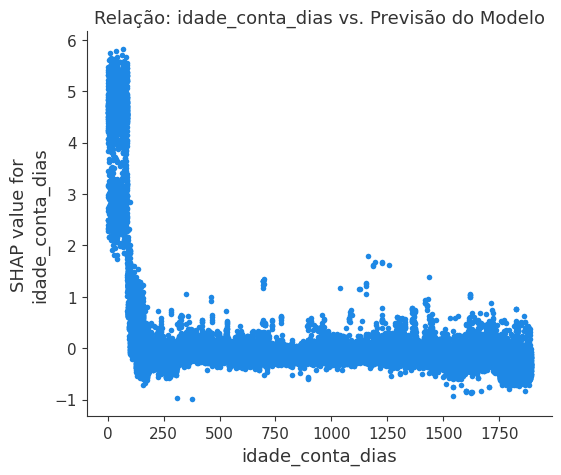

In [63]:
#  Gráfico de Dispersão (Feature Impact vs. Valor) ---
# Útil para mostrar a relação entre o valor da feature e o impacto no output
shap.dependence_plot(colunas_selecionadas[0], shap_values, df_previsores, 
                     interaction_index=None, show=False, 
                     title=f"Relação: {colunas_selecionadas[0]} vs. Previsão do Modelo")

## Interpretação do Gráfico 2 (Interpretabilidade Local)

 - Relação entre "Idade da Conta (em dias)" e o impacto na previsão de fraude

 - Este gráfico mostra como o tempo de existência da conta influencia a decisão do modelo de prever se uma transação é fraudulenta ou não.

   + Eixo X (Horizontal): Dias desde a criação da conta (idade_conta_dias)

   + Eixo Y (Vertical): Valor SHAP (impacto da feature na previsão do modelo) --> ***Quanto maior esse valor maior probabilidade de fraude***

**🔍 Padrões observados:**

1) Contas recentes (baixa idade) tendem a ter valores Valores SHAP positivos, indicando **MAIOR INFLUÊNCIA NA PREVISÃO DE FRAUDE**.

2) À medida que a conta envelhece, os valores SHAP se aproximam de zero ou tornam-se negativos, sugerindo **MENOR RISCO.**

3) Há uma concentração de pontos com alto impacto positivo **(ALTA PROBABILIDADE DE FRAUDE)** em contas com menos de 100 dias.

-------------------------------------------------------------------------------------------------------------------------------

# Relatório final e Conclusão

| Item                          | Resultado Final - Insights                                                                 |
|----------------------------------------------------------------|--------------------------------------------------------------------------------------|
| Melhor Modelo Encontrado                           | LGBM Classifier com Otimização Bayesiana                                           |
| Melhor F1-Score                                    | Média ponderada entre Precisão e Recall -> 90.3%                                                                              |
| Precisão (Classe Fraude)                           | 90% das transações sinalizadas como fraudes, eram de fato, fraudes                 |
| Recall (Classe Fraude)                             | 88% das fraudes foram corretamente detectadas pelo modelo                          |
| Principais Features                                | canal de compra, distancia do envio em km, verificacao de endereco, idade da conta em dias, valor médio de compra do cliente        |
| Features Críticas Identificadas                    | idade_conta_dias → contas novas têm maior risco --- canal -> Aproximadamente 4/5 das fraudes acontecem na WEB |
| Falsos Positivos                                   | 312 transações legítimas classificadas como fraude                                 |
| Falsos Negativos                                   | 383 fraudes não detectadas                                                         |
| Recomendação Técnica                               | Ajustar limiar de decisão de acordo com o prejuízo causado pelas fraudes           |
| Limiar atual                                       | Considera transações com 30% de probabilidade de fraude, como fraude               |
| Recomendação Estratégica                           | Monitorar contas novas com baixa atividade; reforçar validações de endereço, oferecer benefícios exclusivos para migração para o APP |
| Aplicabilidade                                     | Pronto para integração em sistemas antifraude com monitoramento em tempo real      |


-------------------------------------------------------------------------------------------------------------------------------

# 📄 Principais recomendações para otimização de resultados:

**Análise de Risco com Base na Idade da Conta**

📌 Principais Conclusões:
1) Contas recém-criadas representam maior risco de fraude, segundo o modelo.

2) A feature `distancia_envio_km` é a mais preditiva em todo o conjunto de dados, indicando que a distância tem importância crítica na ocorrência de fraudes.

3) Clientes verificados (`verificacao_endereço`) são, teoricamente, menos propensos a praticar fraudes.

4) O impacto da feature `idade_conta_dias` é significativo e deve ser considerado em políticas de prevenção.

**O modelo é sensível á esses fatores, o que reforça a importância de monitorar essas características com mais atenção e se adiantar à eventos indesejados como as fraudes.**

**✅ Recomendações Estratégicas:**

- Reforçar validações para contas com menos de 100 dias de existência.

- Implementar limites progressivos para transações em contas novas.

- Priorizar monitoramento automatizado para usuários com baixo histórico e pouca atividade.

- Integrar essa variável em dashboards operacionais para equipes de risco e compliance.

- Incentivar a verificação de endereço para proteção dos clientes e empresa.

- Monitorar mudanças de endereço e distâncias de forma eficiente, permitindo a prevenção de fraudes de forma proativa. 

# Interpretação e recomendação final para equipe de risco

**🔵 O modelo supera amplamente a linha de base, com desempenho robusto mesmo em limiares de decisão ajustados dinamicamente.**
- ⚙️ Estratégia de Limiar Dinâmico
1) - O limiar de decisão do modelo pode ser ajustado conforme o valor da transação:
2) - Transações altas → limiar mais baixo **(ex:. uma probabilidade de 20% pode ser considerada como fraude)** →Resultado: maior recall (captura mais fraudes)
3) - Transações baixas → limiar mais alto **(ex:. somente transações como uma probabilidade de fraude superior a 70% são sinalizadas)** → maior precisão (menos alarmes falsos )
4) - Essa abordagem equilibra risco financeiro e custo operacional, priorizando alertas em transações mais críticas.
